In [1]:
!pip install -q opencv-python
!pip install pyod
!pip install "pandas<2.0.0"

In [2]:
import tensorflow as tf
from tensorflow import keras
import csv
import cv2
import itertools
import os
import sys
import tempfile
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import pickle
import warnings
# import angle_comuptition
# from angle_comuptition import angle_calculation
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
#dowload and import movnet
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')
warnings.filterwarnings('ignore')

fatal: destination path 'examples' already exists and is not an empty directory.


In [4]:
def detect_person_by_movenet(input_tensor, inference_count=3):
  im_h, im_w, channel = input_tensor.shape
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
  for i in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)
  return person

In [5]:
KEY_POINT_NUMVER = 17
class YogaPosePreprocessor(object):
    def __init__(self,
                 input_images_folder,
                 output_images_folder):
        self._images_in_folder = input_images_folder
        self._images_out_folder = output_images_folder
        self._csvs_out_folder_per_class = tempfile.mkdtemp()

    def process(self):
        """
        Create datafram with keypoints locations for each inpuy image
        """
        #create out folder
        csv_out_path = os.path.join(self._csvs_out_folder_per_class, '.csv')
        if not os.path.exists(self._images_out_folder):
            os.makedirs(self._images_out_folder)

        #write pose condinates of all input image into the output csv
        with open(csv_out_path, 'w') as csv_out_file:
            csv_out_writer = csv.writer(csv_out_file,
                                        delimiter=',',
                                        quoting=csv.QUOTE_MINIMAL)
            image_name = sorted(
                [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])

            image_path = os.path.join(self._images_in_folder,
                                      image_name[0])

            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            person = detect_person_by_movenet(image)
            pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score] for keypoint in person.keypoints],
                                      dtype=np.float32)
            coordinates = pose_landmarks.flatten().astype(str).tolist()
            csv_out_writer.writerow(coordinates)
        self.df_landmarks = self.rename_header_datafram()

    def get_df_landmarks(self):
        return self.df_landmarks

    def rename_header_datafram(self):
        """
        Movenet return x,y cordinates and score of condifident for each body part
        This function is for debug and more visualization of the proccessing
        """
        csv_out_path = os.path.join(self._csvs_out_folder_per_class,'.csv')
        org_df = pd.read_csv(csv_out_path, header=None)

        list_name = [[bodypart.name + '_x', bodypart.name + '_y',
                      bodypart.name + '_score'] for bodypart in BodyPart]
        header_name = []
        for columns_name in list_name:
            header_name += columns_name
        header_map = {org_df.columns[i]: header_name[i]
                      for i in range(len(header_name))}

        org_df.rename(header_map, axis=1, inplace=True)
        return org_df


def get_center_point(landmarks, left_bodypart, right_bodypart):
    """
    Calculates the center point of the two points.
    """

    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    return 0.5 * (left + right)

def get_torso_size(landmarks):
    """
    Calculates torso_size
    """
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                   BodyPart.RIGHT_HIP)
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                        BodyPart.RIGHT_SHOULDER)
    torso_size = tf.linalg.norm(shoulders_center - hips_center) * 2.5
    return torso_size

def get_pose_center(landmarks):
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                       BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    pose_center = tf.broadcast_to(pose_center,
                                      [tf.size(landmarks) // (KEY_POINT_NUMVER * 2), KEY_POINT_NUMVER, 2])
    return pose_center
def get_max_dist_from_center(landmarks):
    """
    Calculates the maximum size of landmark from the center point
    """
    pose_center = get_pose_center(landmarks)
    d = tf.gather(landmarks - pose_center, 0, axis=0,
                  name="dist_to_pose_center")
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))
    return max_dist

def get_pose_size(landmarks):
    """
    Calculates pose size based on torso size and the maximum distance from the
    center point.
    """
    torso_size = get_torso_size(landmarks)
    max_dist = get_max_dist_from_center(landmarks)

    return tf.maximum(torso_size, max_dist)


def normalize_pose(landmarks):
    """
    Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
    """
    pose_center = pose_center = get_pose_center(landmarks)
    normalized_by_center = landmarks - pose_center
    normalized_by_center_size = normalized_by_center / get_pose_size(normalized_by_center)
    return normalized_by_center_size


def get_pose_embedding(landmarks_and_scores):
    """
    Converts pose landmarks and scores into a flattened pose embedding.
    """
    reshaped_inputs = keras.layers.Reshape((KEY_POINT_NUMVER, 3))(landmarks_and_scores)
    landmarks = normalize_pose(reshaped_inputs[:, :, :2])
    embedding = keras.layers.Flatten()(landmarks)
    return embedding


def detect_person_by_movenet(input_tensor):
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)
    return movenet.detect(input_tensor.numpy(),  reset_crop_region=False)

def get_classes_name(csv_path):
    dataframe = pd.read_csv(csv_path)
    classes = dataframe.pop('class_name').unique()
    return classes

def load_pose_landmarks(dataframe):
    """Loads a CSV created by YogaPosePreprocessor.

    Returns:
      X: Detected landmark coordinates and scores of shape (N, 17 * 3)
      y: Ground truth labels of shape (N, label_count)
      classes: The list of all class names found in the dataset
      dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    df_to_process = dataframe.copy()
    X = df_to_process.astype('float64')
    return X

def load_model():
    inputs = tf.keras.Input(shape=(51))
    embedding = get_pose_embedding(inputs)
    layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
    layer = keras.layers.Dropout(0.5)(layer)
    layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
    layer = keras.layers.Dropout(0.5)(layer)
    outputs = keras.layers.Dense(4, activation="softmax")(layer)
    model = keras.Model(inputs, outputs)
    model.load_weights("weights.best.hdf5")
    model.save('myModel')
    return model

def estimation():
    """
    return the pose name of the phto in the data directory
    """
    model = load_model()
    posses_names = get_classes_name('test_data.csv')
    images_in_new = 'data'
    images_out_new = 'poses_images_new'
    preprocessor = YogaPosePreprocessor(
        images_in_new,
        images_out_new
    )
    preprocessor.process()
    get_df_landmarks = preprocessor.get_df_landmarks()
    X_new = load_pose_landmarks(get_df_landmarks)
    line = model.predict(X_new)
    X_new.to_pickle("pose_data")
    return posses_names[np.argmax(line)]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd drive/MyDrive/yoga_poses

/content/drive/MyDrive/yoga_poses


In [8]:

def create_csv_dataset_from_image(dataset):
  if not os.path.isdir(dataset):
    raise Exception("dataset is not a valid directory")
  images_in_train_folder = os.path.join(dataset, 'train')
  images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'
  images_in_test_folder = os.path.join(dataset, 'test')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = YogaPosePreprocessor(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path,
  )

  preprocessor.process(per_pose_class_limit=None)


  preprocessor = YogaPosePreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

  preprocessor.process(per_pose_class_limit=None)

In [9]:
def load_pose_landmarks(csv_path):
  """
    Load pose landmarks from a CSV file and preprocess the data for model training.

    Parameters:
    csv_path (str): The file path to the CSV file containing the pose landmarks data.

    Returns:
    tuple: A tuple containing:
        - X (pd.DataFrame): A DataFrame of the feature data, with each column representing a pose landmark.
        - y (np.ndarray): A one-hot encoded array of the class labels.
        - classes (np.ndarray): An array of unique class names.
        - dataframe (pd.DataFrame): The original DataFrame loaded from the CSV file.

    The CSV file is expected to have the following columns:
    - 'class_name': The name of the class for each data point (cobra, tree etc.).
    - 'class_no': The numeric label for each class.
    - 'file_name': The name of the file associated with each data point (used for identification, not features).
    - Pose landmark columns: Columns representing pose landmarks (these should be numeric).
  """
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()
  classes = df_to_process.pop('class_name').unique()
  y = df_to_process.pop('class_no')
  X_name = df_to_process['file_name']
  df_to_process.drop(columns=['file_name'], inplace=True)
  X = df_to_process.astype('float64')
  y = to_categorical(y, 4)
  return X, y, classes, dataframe

In [10]:
csvs_out_train_path = "train_data.csv"
csvs_out_test_path = "test_data.csv"
X, y, class_names, dataframe = load_pose_landmarks(csvs_out_train_path)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)


In [11]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """
    Calculates the center point of the two points.
    """

    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    return 0.5 * (left + right)


def get_torso_size(landmarks):
    """
    Calculates torso_size
    """
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                   BodyPart.RIGHT_HIP)
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                        BodyPart.RIGHT_SHOULDER)
    torso_size = tf.linalg.norm(shoulders_center - hips_center) * 2.5
    return torso_size

def get_pose_center(landmarks):
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                       BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    pose_center = tf.broadcast_to(pose_center,
                                      [tf.size(landmarks) // (KEY_POINT_NUMVER * 2), KEY_POINT_NUMVER, 2])
    return pose_center
def get_max_dist_from_center(landmarks):
    """
    Calculates the maximum size of landmark from the center point
    """
    pose_center = get_pose_center(landmarks)
    d = tf.gather(landmarks - pose_center, 0, axis=0,
                  name="dist_to_pose_center")
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))
    return max_dist

def get_pose_size(landmarks):
    """
    Calculates pose size based on torso size and the maximum distance from the
    center point.
    """
    torso_size = get_torso_size(landmarks)
    max_dist = get_max_dist_from_center(landmarks)

    return tf.maximum(torso_size, max_dist)


def normalize_pose(landmarks):
    """
    Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
    """
    pose_center = pose_center = get_pose_center(landmarks)
    normalized_by_center = landmarks - pose_center
    normalized_by_center_size = normalized_by_center / get_pose_size(normalized_by_center)
    return normalized_by_center_size

def get_pose_embedding(landmarks_and_scores):
    """
    Converts pose landmarks and scores into a flattened pose embedding.
    """
    reshaped_inputs = keras.layers.Reshape((KEY_POINT_NUMVER, 3))(landmarks_and_scores)
    landmarks = normalize_pose(reshaped_inputs[:, :, :2])
    embedding = keras.layers.Flatten()(landmarks)
    return embedding

In [12]:
inputs = tf.keras.Input(shape=(51))
embedding = get_pose_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(4, activation="softmax")(layer)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 17, 3)                0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 2)                0         ['reshape[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpL  (None, 2)                    0         ['tf.__operators__.getitem

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print("loss is ", loss)
print("f1_score is ", f1_score)
print("precision is ", precision)
print("recall is ", recall)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

loss is  0.199416384100914
f1_score is  0.9341257214546204
precision is  0.9466257095336914
recall is  0.9232954382896423
Epoch 1/200
103/113 [==========================>...] - ETA: 0s - loss: 0.1805 - accuracy: 0.9575 - f1_m: 0.9585 - precision_m: 0.9690 - recall_m: 0.9490
Epoch 1: val_accuracy improved from -inf to 0.95912, saving model to weights.best.hdf5
113/113 [==============================] - 2s 16ms/step - loss: 0.1774 - accuracy: 0.9589 - f1_m: 0.9600 - precision_m: 0.9701 - recall_m: 0.9508 - val_loss: 0.1737 - val_accuracy: 0.9591 - val_f1_m: 0.9596 - val_precision_m: 0.9707 - val_recall_m: 0.9500
Epoch 2/200
100/113 [=========================>....] - ETA: 0s - loss: 0.1438 - accuracy: 0.9725 - f1_m: 0.9697 - precision_m: 0.9776 - recall_m: 0.9625
Epoch 2: val_accuracy improved from 0.95912 to 0.96226, saving model to weights.best.hdf5
113/113 [==============================] - 1s 6ms/step - loss: 0.1382 - accuracy: 0.9728 - f1_m: 0.9704 - precision_m: 0.9774 - recall_m: 0

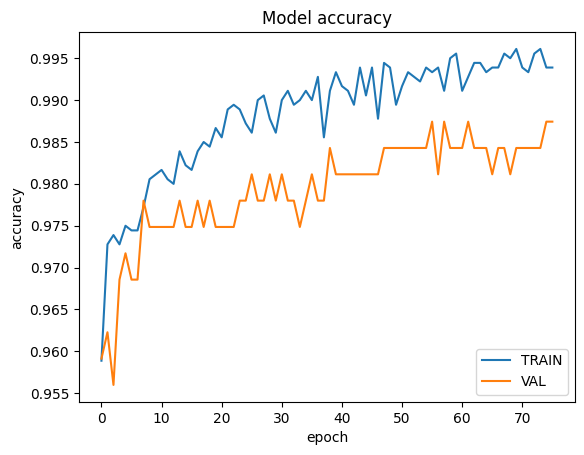

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

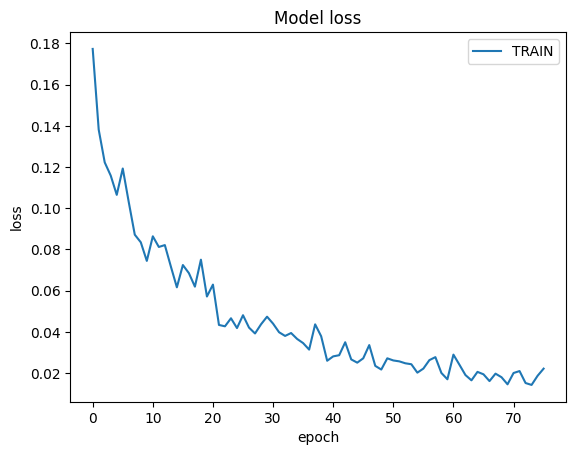

In [15]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN'], loc='upper right')
plt.show()


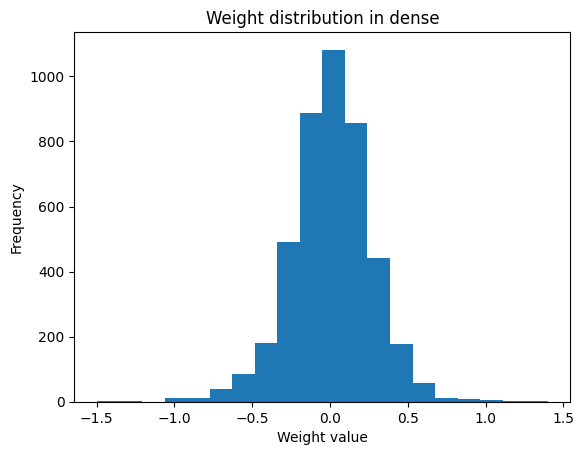

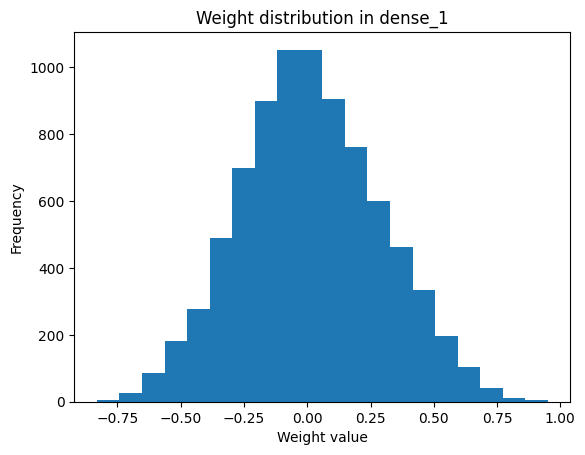

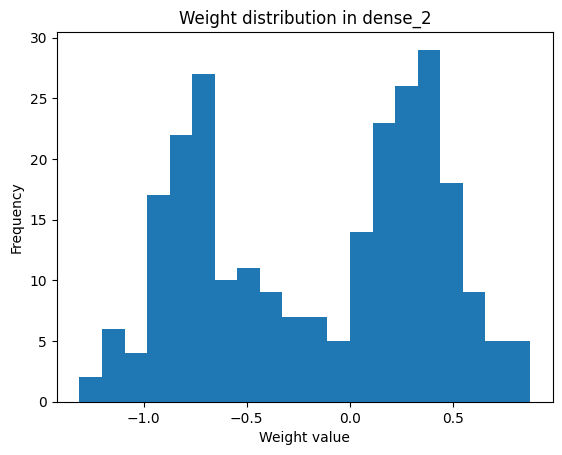

In [16]:
for layer in model.layers:
    if 'dense' in layer.name:
        weights, biases = layer.get_weights()
        plt.hist(weights.flatten(), bins=20)
        plt.title(f'Weight distribution in {layer.name}')
        plt.xlabel('Weight value')
        plt.ylabel('Frequency')
        plt.show()


10/10 [==============================] - 0s 2ms/step


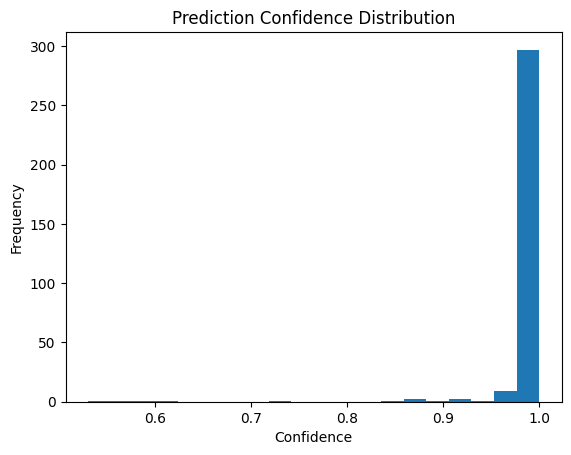

In [17]:
predictions = model.predict(X_val)
prediction_confidences = np.max(predictions, axis=1)

plt.hist(prediction_confidences, bins=20)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.show()


10/10 [==============================] - 0s 3ms/step


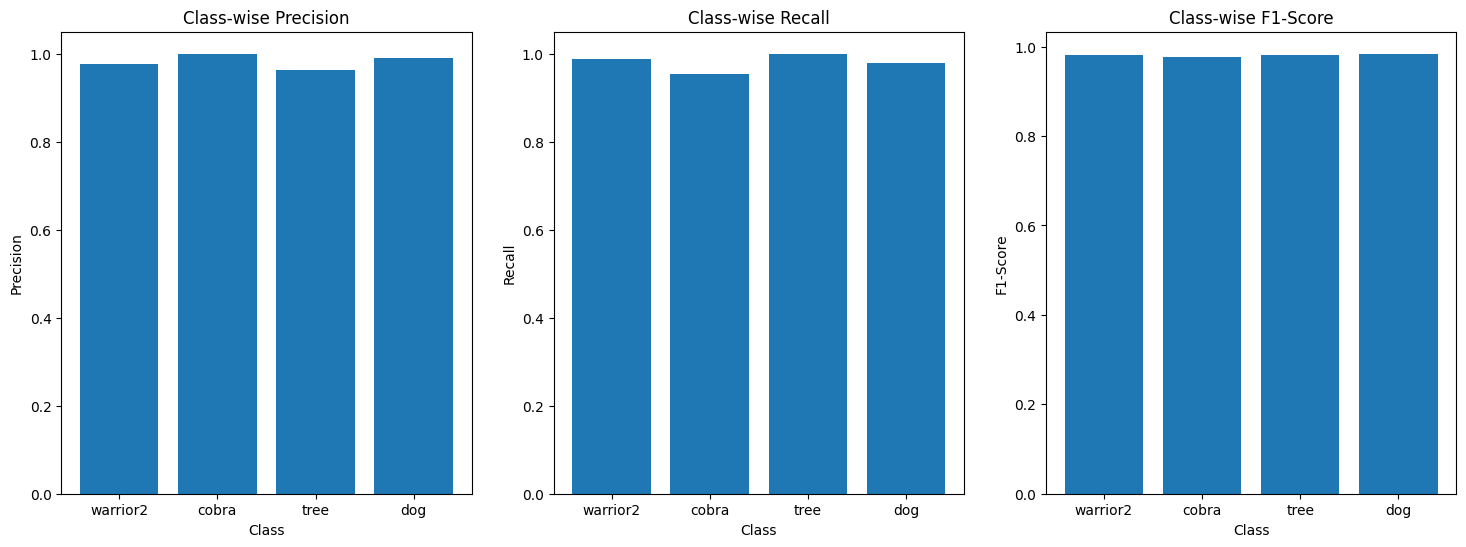

In [18]:
from sklearn.metrics import classification_report
pose_model_names = ["warrior2", "cobra", "tree", "dog"]
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
report = classification_report(y_true, y_pred, target_names=pose_model_names, output_dict=True)

# Plot precision, recall, f1-score for each class
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Filter out class-specific entries from the report
class_specific_report = {key: report[key] for key in pose_model_names}

ax[0].bar(class_specific_report.keys(), [class_specific_report[class_name]['precision'] for class_name in pose_model_names])
ax[0].set_title('Class-wise Precision')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Precision')


ax[1].bar(class_specific_report.keys(), [class_specific_report[class_name]['recall'] for class_name in pose_model_names])
ax[1].set_title('Class-wise Recall')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Recall')

ax[2].bar(class_specific_report.keys(), [class_specific_report[class_name]['f1-score'] for class_name in pose_model_names])
ax[2].set_title('Class-wise F1-Score')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('F1-Score')

plt.show()


In [19]:
def save_pose_pickle(pose_name):
  pose = dataframe[dataframe.class_name.str.contains(pose_name)]
  pose.pop('class_name').unique()
  y = pose.pop('class_no')
  X_name = pose['file_name']
  pose.drop(columns=['file_name'], inplace=True)
  X = pose.astype('float64')
  X = X.assign(file_name=X_name)
  X.to_pickle(pose_name)

In [20]:
pose_model_names = ["warrior2", "cobra", "tree", "dog"]
for pose_name in pose_model_names:
  save_pose_pickle(pose_name)

In [21]:
# model.save_weights("weightmodel.best.hdf5")